<a href="https://colab.research.google.com/github/danielbauer1979/MSDIA_PredictiveModelingAndMachineLearning/blob/main/GB886_III_8_GLMCaseStudy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Claim Counts

This tutorial presents a study in the context of auto liability insurance focusing on claim counts.

The data set is well known in the actuarial literature. The data source is the book edited by Arthur Charpentier entitled *Computational Actuarial Science with R*, (2016), by CRC Press. In this tutorial, we utilize ideas from:

*   Professor Dani Bauer's tutorials available at his [Github site](https://github.com/danielbauer1979/MSDIA_PredictiveModelingAndMachineLearning).
*   Dr. Patrick Laub's presentation at his course [Artificial Intelligence and Deep Learning Models for Actuarial Applications](https://laub.au/DeepLearningForActuaries/)
*  A case study by Noll, Salman, Wütrich (2020), *Case Study: French Motor Third-Party Liability Claims*, available at [SSRN](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3164764) with [R code](https://github.com/actuarial-data-science/Tutorials/tree/master/1%20-%20French%20Motor%20Third-Party%20Liability%20Claims).
   *  This case study was the basis for a [tutorial by Professor Mario Wütrich](https://github.com/JSchelldorfer/DeepLearningWithActuarialApplications/blob/master/DeepLearningWithActuarialApplications.pdf).


As is the custom with Jupyter notebooks, we start by loading the libraries that are going to be helpful. We're going to rely on the statistical learning toolkit ski-cit learn, which provides GLM functionalty but also will be used in the context of other ML models. It is less comfortable to use than some of the other packages. But it is versatile and fast, and therefore one of the most popular predictive modeling toolkits.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PoissonRegressor
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import StandardScaler
import random
from keras.models import Sequential
from keras.layers import Dense



We consider predictive modeling of auto claims, i.e. the overarching challenge is predicting frequencies claims.  We rely on the comprehensive French Motor Third-Part Liability dataset.

We have uploaded the data to our Github site [Actuarial Regression](https://github.com/OpenActTextDev/ActuarialRegression/tree/main). For R users, the data `freMTPLfreq` is  available within the [package CASdatasets](http://cas.uqam.ca/).


Let's take a peak at the  dataset:

In [ ]:
dat_frq = pd.read_csv("https://raw.githubusercontent.com/OpenActTextDev/ActuarialRegression/refs/heads/main/CourseCSVData/freMTPL2freq.csv")


In [ ]:
dat_frq.head()

,Unnamed: 0,IDpol,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimTotal,ClaimNb
0,1,1.0,0.10,D,5,0,55,50,B12,Regular,1217,R82,0.0,0
1,2,3.0,0.77,D,5,0,55,50,B12,Regular,1217,R82,0.0,0
2,3,5.0,0.75,B,6,2,52,50,B12,Diesel,54,R22,0.0,0
3,4,10.0,0.09,B,7,0,46,50,B12,Diesel,76,R72,0.0,0
4,5,11.0,0.84,B,7,0,46,50,B12,Diesel,76,R72,0.0,0


Here are some brief descriptions of the variables:

- `IDpol`: policy number (unique identifier)
- `ClaimNb`: number of claims on the given policy
- `Exposure`: total exposure in yearly units
- `Area`: area code (categorical, ordinal)
- `VehPower`: power of the car (categorical, ordinal)
- `VehAge`: age of the car in years
- `DrivAge`: age of the (most common) driver in years
- `BonusMalus`: bonus-malus level between 50 and 230 (with reference level 100)
- `VehBrand`: car brand (categorical, nominal)
- `VehGas`: diesel or regular fuel car (binary)
- `Density`: density of inhabitants per km^2^ in the city of the living place of the driver
- `Region`: regions in France (prior to 2016)

Note that the variable 'Area' is defined as an ordinal variable. In their development of the case, Noll, Salman, Wütrich (2020) carefully describe how some areas are bigger than others, so that the variable can be considered as nominal. This is an interesting extension. Because of the overlap and the categorical variable 'Region', we will exclude the variable 'Area' from our analysis.

In [ ]:
dat_frq.describe(percentiles=[.01, .5, .9999])

,Unnamed: 0,IDpol,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,ClaimTotal,ClaimNb
count,678007.000000,6.780070e+05,678007.000000,678007.000000,678007.000000,678007.000000,678007.000000,678007.000000,6.780070e+05,678007.000000
mean,339006.690991,2.621857e+06,0.528547,6.454653,7.044218,45.499061,59.761588,1792.430975,8.816661e+01,0.038913
std,195726.329549,1.641789e+06,0.364081,2.050902,5.666235,14.137492,15.636700,3958.663031,5.822068e+03,0.204752
min,1.000000,1.000000e+00,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000,0.000000e+00,0.000000
1%,6781.060000,1.993412e+04,0.008219,4.000000,0.000000,20.000000,50.000000,10.000000,0.000000e+00,0.000000
50%,339008.000000,2.272153e+06,0.490000,6.000000,6.000000,44.000000,50.000000,393.000000,0.000000e+00,0.000000
99.99%,677945.199400,6.114262e+06,1.000000,15.000000,69.000000,99.000000,158.000000,27000.000000,6.542946e+04,3.000000
max,678013.000000,6.114330e+06,1.000000,15.000000,100.000000,100.000000,230.000000,27000.000000,4.075401e+06,5.000000


Some extreme values of 'VehAge' and 'BonusMalus' are unrealistic. Let's "clip" them to be at the 99.99th percentile.

In [ ]:
upper_limit1 = dat_frq["VehAge"].quantile(0.9999)
dat_frq["VehAge"] = dat_frq["VehAge"].clip(upper=upper_limit1)
upper_limit2 = dat_frq["BonusMalus"].quantile(0.9999)
dat_frq["BonusMalus"] = dat_frq["BonusMalus"].clip(upper=upper_limit2)
dat_frq.describe(percentiles=[.01, .5, .9999])

,Unnamed: 0,IDpol,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,ClaimTotal,ClaimNb
count,678007.000000,6.780070e+05,678007.000000,678007.000000,678007.000000,678007.000000,678007.000000,678007.000000,6.780070e+05,678007.000000
mean,339006.690991,2.621857e+06,0.528547,6.454653,7.041803,45.499061,59.759343,1792.430975,8.816661e+01,0.038913
std,195726.329549,1.641789e+06,0.364081,2.050902,5.633650,14.137492,15.620216,3958.663031,5.822068e+03,0.204752
min,1.000000,1.000000e+00,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000,0.000000e+00,0.000000
1%,6781.060000,1.993412e+04,0.008219,4.000000,0.000000,20.000000,50.000000,10.000000,0.000000e+00,0.000000
50%,339008.000000,2.272153e+06,0.490000,6.000000,6.000000,44.000000,50.000000,393.000000,0.000000e+00,0.000000
99.99%,677945.199400,6.114262e+06,1.000000,15.000000,69.000000,99.000000,158.000000,27000.000000,6.542946e+04,3.000000
max,678013.000000,6.114330e+06,1.000000,15.000000,69.000000,100.000000,158.000000,27000.000000,4.075401e+06,5.000000


We now summarize the target variable 'ClaimsNb' in a bit more detail.

In [ ]:
pd.crosstab(index=dat_frq['ClaimNb'], columns="count")

col_0,count
ClaimNb,
0,653069
1,23571
2,1298
3,62
4,5
5,2


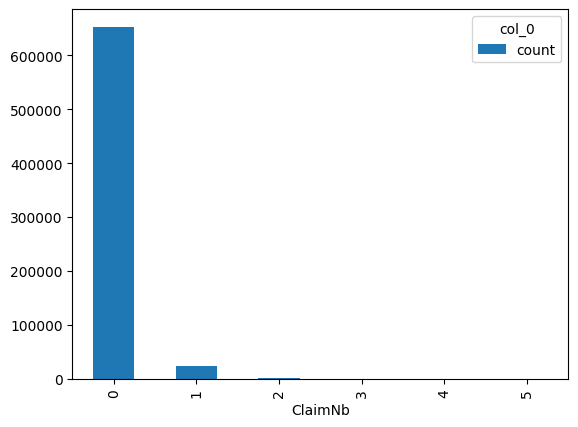

In [ ]:
pd.crosstab(index=dat_frq['ClaimNb'], columns="count").plot(kind='bar');

So, as expected, multiple claims are rare. The vast majority of cases don't have a claim.


Let's do some visualizations of some of the feature variables:

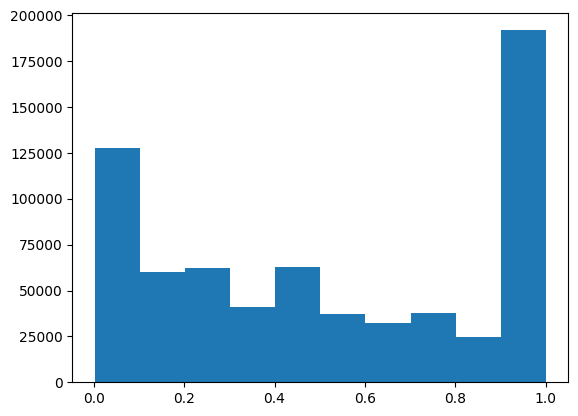

In [ ]:
plt.hist(dat_frq['Exposure'])
plt.show()

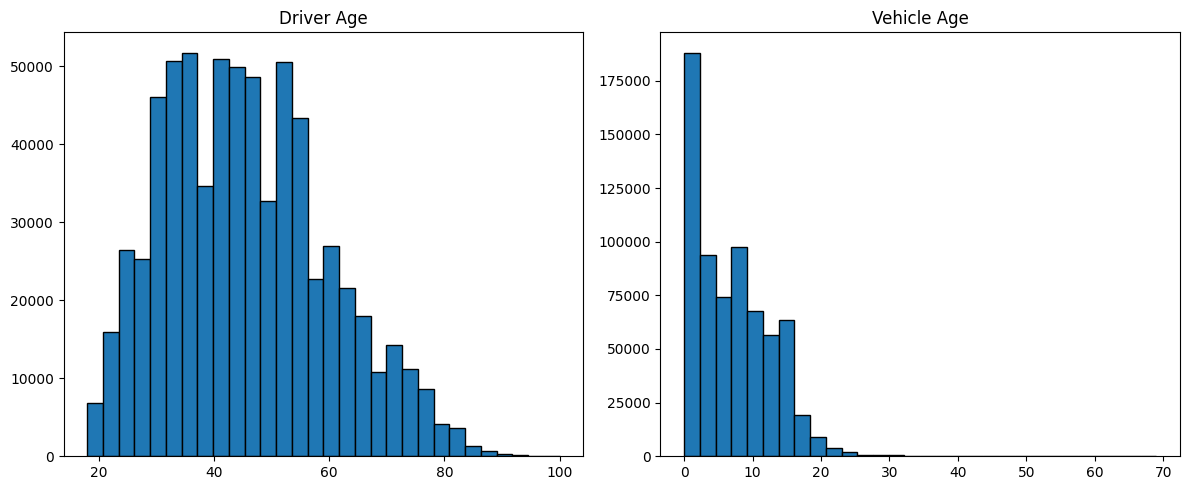

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # (rows, columns)

# First plot
axes[0].hist(dat_frq['DrivAge'], bins=30, edgecolor="black")
axes[0].set_title('Driver Age')

# Second plot (example)
axes[1].hist(dat_frq['VehAge'], bins=30, edgecolor="black")
axes[1].set_title('Vehicle Age')

plt.tight_layout()
plt.show()


For the variable 'Density', we see that it looks like very small and a few very high densities. As is common, we go to log-scale.

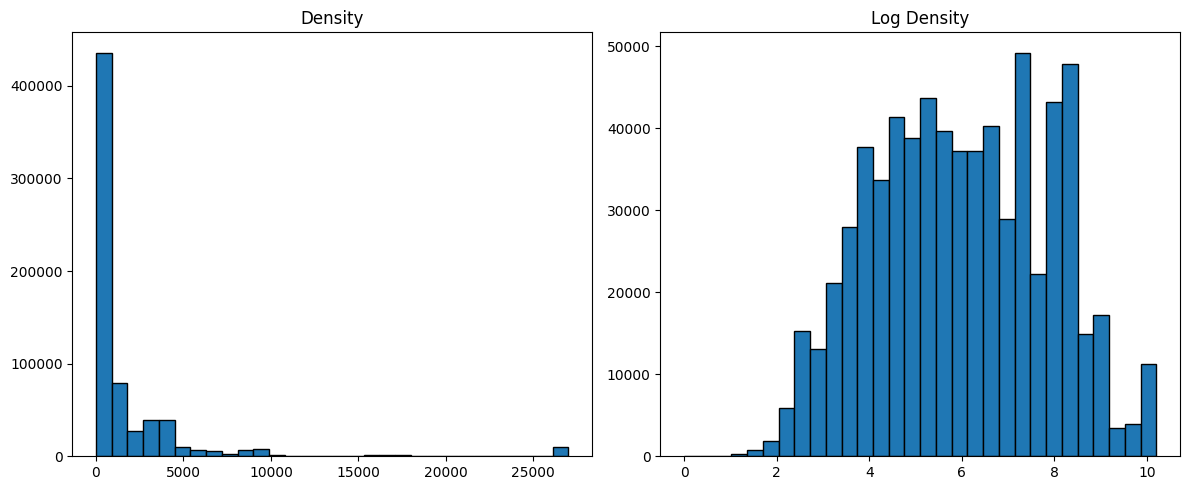

In [ ]:
dat_frq.loc[:, 'LogDensity'] = np.log(dat_frq['Density'])
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # (rows, columns)

# First plot
axes[0].hist(dat_frq['Density'], bins=30, edgecolor="black")
axes[0].set_title('Density')

# Second plot (example)
axes[1].hist(dat_frq['LogDensity'], bins=30, edgecolor="black")
axes[1].set_title('Log Density')

plt.tight_layout()
plt.show()


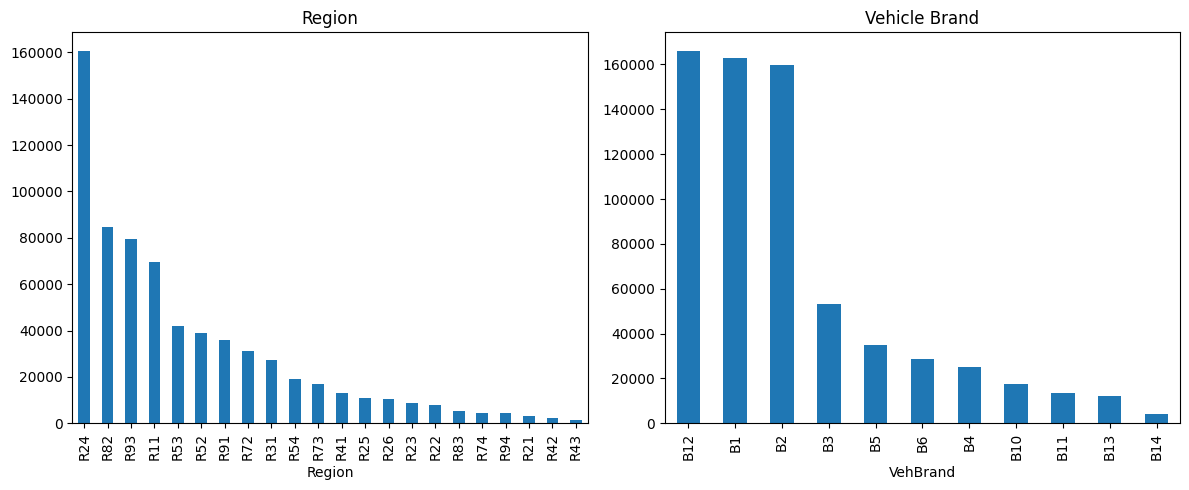

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # (rows, columns)

# First plot
dat_frq["Region"].value_counts().plot(kind="bar", ax=axes[0])
axes[0].set_title('Region')

# Second plot (example)
dat_frq["VehBrand"].value_counts().plot(kind="bar", ax=axes[1])
axes[1].set_title('Vehicle Brand')

plt.tight_layout()
plt.show()

# Building a GLM

Now, let us create a new data set, removing variables not needed for our analysis:


In [ ]:
dat_frq.info()
dat_New = dat_frq.drop(dat_frq.columns[[0, 1, 3, 10, 12]], axis=1)
dat_New.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678007 entries, 0 to 678006
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  678007 non-null  int64  
 1   IDpol       678007 non-null  float64
 2   Exposure    678007 non-null  float64
 3   Area        678007 non-null  object 
 4   VehPower    678007 non-null  int64  
 5   VehAge      678007 non-null  int64  
 6   DrivAge     678007 non-null  int64  
 7   BonusMalus  678007 non-null  int64  
 8   VehBrand    678007 non-null  object 
 9   VehGas      678007 non-null  object 
 10  Density     678007 non-null  int64  
 11  Region      678007 non-null  object 
 12  ClaimTotal  678007 non-null  float64
 13  ClaimNb     678007 non-null  int64  
 14  LogDensity  678007 non-null  float64
dtypes: float64(4), int64(7), object(4)
memory usage: 77.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678007 entries, 0 to 678006
Data columns (total 10 columns):
 

We need to put the categorical variables to dummies. For that, we separate the dummies and the numerical variables, make the dummies, and then concatenate. Here are the categorical variables.

In [ ]:
dat_New[dat_New.columns[[1, 4, 5, 6, 7]]].head()

,VehPower,BonusMalus,VehBrand,VehGas,Region
0,5,50,B12,Regular,R82
1,5,50,B12,Regular,R82
2,6,50,B12,Diesel,R22
3,7,50,B12,Diesel,R72
4,7,50,B12,Diesel,R72


In [ ]:
dummies = pd.get_dummies(dat_New[dat_New.columns[[1, 4, 5, 6, 7]]],drop_first=True)
dat_New = dat_New.drop(dat_New.columns[[1, 4, 5, 6, 7]], axis=1)
dat_New = pd.concat([dat_New,dummies], axis=1)
dat_New.head()


,Exposure,VehAge,DrivAge,ClaimNb,LogDensity,VehPower,BonusMalus,VehBrand_B10,VehBrand_B11,VehBrand_B12,...,Region_R53,Region_R54,Region_R72,Region_R73,Region_R74,Region_R82,Region_R83,Region_R91,Region_R93,Region_R94
0,0.10,0,55,0,7.104144,5,50,False,False,True,...,False,False,False,False,False,True,False,False,False,False
1,0.77,0,55,0,7.104144,5,50,False,False,True,...,False,False,False,False,False,True,False,False,False,False
2,0.75,2,52,0,3.988984,6,50,False,False,True,...,False,False,False,False,False,False,False,False,False,False
3,0.09,0,46,0,4.330733,7,50,False,False,True,...,False,False,True,False,False,False,False,False,False,False
4,0.84,0,46,0,4.330733,7,50,False,False,True,...,False,False,True,False,False,False,False,False,False,False


And, to save time later, let's go ahead and rescale the continuous features. It is not necessary for the Poisson regression fit but will be helpful later when we run the neural net fits.

In [ ]:
#from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
cols_to_scale = ['VehAge', 'DrivAge', 'BonusMalus', 'Density']
dat_frq[cols_to_scale] = scaler.fit_transform(dat_frq[cols_to_scale])

Let's define the target variable, the number of claims, and the features.

In [ ]:
y_freq = dat_New['ClaimNb']
X = dat_New.drop(columns = ['ClaimNb'])
#X = pd.get_dummies(X)
X


,Exposure,VehAge,DrivAge,LogDensity,VehPower,BonusMalus,VehBrand_B10,VehBrand_B11,VehBrand_B12,VehBrand_B13,...,Region_R53,Region_R54,Region_R72,Region_R73,Region_R74,Region_R82,Region_R83,Region_R91,Region_R93,Region_R94
0,0.10000,0,55,7.104144,5,50,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
1,0.77000,0,55,7.104144,5,50,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
2,0.75000,2,52,3.988984,6,50,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
3,0.09000,0,46,4.330733,7,50,False,False,True,False,...,False,False,True,False,False,False,False,False,False,False
4,0.84000,0,46,4.330733,7,50,False,False,True,False,...,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678002,0.00274,0,54,8.106816,4,50,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
678003,0.00274,0,41,9.195227,4,95,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
678004,0.00274,2,45,7.187657,6,50,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
678005,0.00274,0,60,4.553877,4,50,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False


As before, define versions for training, validation, and testing.

In [ ]:
# Thanks https://datascience.stackexchange.com/a/15136
X_main, X_test, y_main, y_test = train_test_split(
    X, y_freq, test_size=0.2, random_state=1
)                                                                   #<1>

# As 0.25 x 0.8 = 0.2
X_train, X_val, y_train, y_val = train_test_split(
    X_main, y_main, test_size=0.25, random_state=1
)                                                                   #<2>

X_train.shape, X_val.shape, X_test.shape


((406803, 38), (135602, 38), (135602, 38))

And let's model frequencies via a Poisson Regression:

In [ ]:
#from sklearn.linear_model import PoissonRegressor
freqmodel = PoissonRegressor()
XReg = X_train.astype(int)
freqmodel.fit(XReg,y_train)
preds_train = freqmodel.predict(XReg)
np.corrcoef(preds_train,y_train);

This is not a great correlation. Let us dig into this a bit more deeply.

In [ ]:
#import statsmodels.api as sm
XReg = X_train.astype(int)
XReg = sm.add_constant(XReg)  # manually add intercept
poisson_model = sm.GLM(y_train, XReg, family=sm.families.Poisson()).fit()
print(poisson_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               406803
Model:                            GLM   Df Residuals:                   406764
Model Family:                 Poisson   Df Model:                           38
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -65788.
Date:                Sat, 26 Apr 2025   Deviance:                   1.0112e+05
Time:                        19:21:36   Pearson chi2:                 4.47e+05
No. Iterations:                     7   Pseudo R-squ. (CS):            0.01060
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -5.7138      0.074    -77.

Many statistically significant variables. Not unexpected for a data set of this size. Are they important?

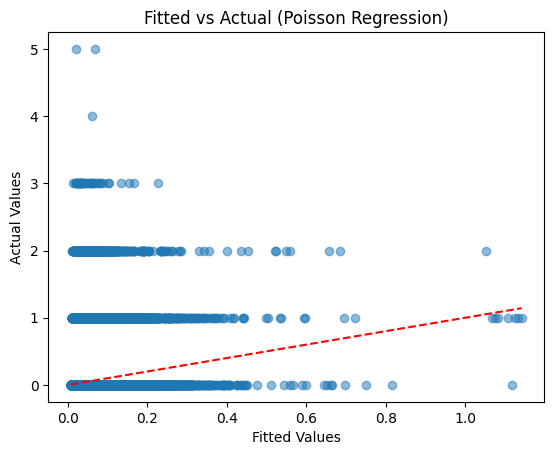

In [ ]:
y_pred_train = poisson_model.fittedvalues
plt.scatter(y_pred_train, y_train, alpha=0.5)
plt.plot([y_pred_train.min(), y_pred_train.max()], [y_pred_train.min(), y_pred_train.max()], 'r--')  # 45-degree line
plt.xlabel("Fitted Values")
plt.ylabel("Actual Values")
plt.title("Fitted vs Actual (Poisson Regression)")
plt.show()


The correlation is fairly low, but when we look at a scatter plot...

It does seem like that the claims with higher frequencies have higher predictions, though they are still close to zero. Accurately predicting car accidents is just very difficult.

In [ ]:
#from sklearn.metrics import mean_absolute_error as mae

mae_train = mae(y_train, y_pred_train)
print("MAE Training", mae_train)
XReg_val = X_val.astype(int)
XReg_val = sm.add_constant(XReg_val)  # manually add intercept
y_pred_val = poisson_model.predict(XReg_val)

mae_val = mae(y_val, y_pred_val)
print("MAE Validation:", mae_val)

y_pred_zeros = np.zeros_like(y_val)
mae_zeros = mae(y_val, y_pred_zeros)
print("MAE Zeros:", mae_zeros)

MAE Training 0.07401397464346478
MAE Validation: 0.07365074652468814
MAE Zeros: 0.03863512337576142


As anticipated, the validation mean absolute value is lower than that for training.

We can compare this to a naive predictor, equal to zero for all observations. At least we are doing better than this naive predictor!


# Neural Network Methods

Let's see if we could do better with a neural network approach.

In [ ]:
X_train.info()
X_train.describe(percentiles=[.01, .5, .9999])


<class 'pandas.core.frame.DataFrame'>
Index: 406803 entries, 29023 to 5541
Data columns (total 38 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Exposure        406803 non-null  float64
 1   VehAge          406803 non-null  int64  
 2   DrivAge         406803 non-null  int64  
 3   LogDensity      406803 non-null  float64
 4   VehPower        406803 non-null  int64  
 5   BonusMalus      406803 non-null  int64  
 6   VehBrand_B10    406803 non-null  bool   
 7   VehBrand_B11    406803 non-null  bool   
 8   VehBrand_B12    406803 non-null  bool   
 9   VehBrand_B13    406803 non-null  bool   
 10  VehBrand_B14    406803 non-null  bool   
 11  VehBrand_B2     406803 non-null  bool   
 12  VehBrand_B3     406803 non-null  bool   
 13  VehBrand_B4     406803 non-null  bool   
 14  VehBrand_B5     406803 non-null  bool   
 15  VehBrand_B6     406803 non-null  bool   
 16  VehGas_Regular  406803 non-null  bool   
 17  Region_R21   

,Exposure,VehAge,DrivAge,LogDensity,VehPower,BonusMalus
count,406803.000000,406803.000000,406803.000000,406803.000000,406803.000000,406803.000000
mean,0.528917,7.046362,45.500513,5.981960,6.453529,59.765095
std,0.364115,5.632755,14.133815,1.870612,2.050140,15.616495
min,0.002732,0.000000,18.000000,0.000000,4.000000,50.000000
1%,0.008219,0.000000,21.000000,2.302585,4.000000,50.000000
50%,0.490000,6.000000,44.000000,5.973810,6.000000,50.000000
99.99%,1.000000,66.639600,99.000000,10.203592,15.000000,158.000000
max,1.000000,69.000000,100.000000,10.203592,15.000000,158.000000


In [ ]:
#from keras.models import Sequential
#from keras.layers import Dense
#import random

random.seed(2025)

model = Sequential([
    Dense(64, activation='leaky_relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='leaky_relu'),
    Dense(1, activation='exponential')
])

model.compile(optimizer='adam', loss='mae')
model.summary();

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         2,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,609 (18.00 KB)

 Trainable params: 4,609 (18.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
%time hist = model.fit(X_train, y_train, epochs=25, validation_data=(X_val, y_val), verbose=True)
hist.history["loss"]

Epoch 1/25
12713/12713 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - loss: 138.8119 - val_loss: 0.0402
Epoch 2/25
12713/12713 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - loss: 0.0395 - val_loss: 0.0386
Epoch 3/25
12713/12713 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 0.0389 - val_loss: 0.0386
Epoch 4/25
12713/12713 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - loss: 0.0389 - val_loss: 0.0386
Epoch 5/25
12713/12713 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - loss: 0.0388 - val_loss: 0.0386
Epoch 6/25
12713/12713 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - loss: 0.0388 - val_loss: 0.0386
Epoch 7/25
12713/12713 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - loss: 0.0391 - val_loss: 0.0386
Epoch 8/25
12713/12713 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - loss: 0.0393 - val_loss: 0.0386
Epoch 9/25
12713/12713 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - loss: 0.0385 - val_loss: 0.0386
Epoch 10/25
12713/12713 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - loss: 0.0390 - val_loss: 0.0386
Epoch 11/25
12713/12713 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - loss: 0.0389 - val_loss: 0.

[14.313061714172363,
 0.039204277098178864,
 0.0389820858836174,
 0.03898201510310173,
 0.03898201510310173,
 0.03898201510310173,
 0.03898201510310173,
 0.03898201510310173,
 0.03898201510310173,
 0.03898201510310173,
 0.03898201510310173,
 0.03898201510310173,
 0.03898201510310173,
 0.03898201510310173,
 0.03898201510310173,
 0.03898201510310173,
 0.03898201510310173,
 0.03898201510310173,
 0.03898201510310173,
 0.03898201510310173,
 0.03898201510310173,
 0.03898201510310173,
 0.03898201510310173,
 0.03898201510310173,
 0.03898201510310173]

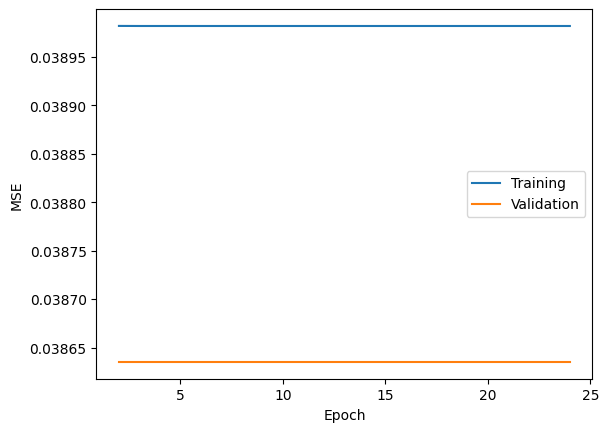

In [ ]:
plt.plot(range(2, 25), hist.history["loss"][2:])
plt.plot(range(2, 25),  hist.history["val_loss"][2:])

plt.legend(["Training", "Validation"])
plt.xlabel("Epoch")
plt.ylabel("MSE");